In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

In [3]:
from datetime import datetime
import geopy.distance
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric_temporal
from tqdm import tqdm

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_version_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_convert_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_diag_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_spmm_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_spspmm_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_metis_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_rw_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_saint_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_sample_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_ego_sample_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\torch_sparse\_hgt_sample_cuda.pyd
c:\Users\srush\miniconda3\envs\cnncuda\lib\

In [4]:
from torch_geometric_temporal.nn import STConv

In [5]:
import torch

# Checks if CUDA is available
cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")

# If CUDA is available, it also prints the version
if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")


CUDA Available: True
CUDA Version: 11.6
Number of CUDA Devices: 1
CUDA Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


Loading the cleaned data with JC stations

In [20]:
all_df = pd.read_pickle(r'C:\Users\srush\bike share model\cleaned&merged_data\All_Rides.pkl')

In [21]:
all_df.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,121DD7DD23CB1335,2021-02-03 23:11:28,2021-02-03 23:18:28,Hoboken Ave at Monmouth St,JC105,Christ Hospital,JC034,40.735208,-74.046964,40.734786,-74.050444,member
1,FD73FB85F008349D,2021-02-27 16:34:05,2021-02-27 16:56:40,Newport Pkwy,JC008,Marin Light Rail,JC013,40.728744,-74.032108,40.714584,-74.042817,member
2,39F9E6663CB5FDF6,2021-02-26 23:16:04,2021-02-26 23:22:25,Journal Square,JC103,Baldwin at Montgomery,JC020,40.733670,-74.062500,40.723659,-74.064194,member
3,A64745CB0792EC6F,2021-02-24 16:51:50,2021-02-24 17:16:09,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,casual
4,75CC76EB9543764A,2021-02-24 20:44:16,2021-02-24 20:44:46,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,member


In [22]:
# Filtering JC Stations for analysis
jc_stations = ['JC102', 'JC096', 'JC0003', 'JC099', 'JC023', 'JC081', 'JC075', 'JC078', 'JC063', 'JC080', 'JC072', 'JC013', 'JC002', 'JC076', 'JC032', 'JC027', 'JC009', 'JC105', 'JC053', 'JC093', 'JC020', 'JC094', 'JC056', 'JC103', 'JC038', 'JC006', 'JC104', 'JC008', 'JC0084', 'JC065', 'JC024', 'JC059', 'JC0011', 'JC0035', 'JC005', 'JC082', 'JC074', 'JC055', 'JC022', 'JC106', 'JC014', 'JC098', 'JC066', 'JC052', 'JC051', 'JC077', 'JC0095', 'JC019', 'JC018', 'JC0034', 'JC057']

df = all_df[(all_df['start_station_id'].isin(jc_stations)) & (all_df['end_station_id'].isin(jc_stations))]

In [23]:
#converting to date and time type
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

C:\Users\srush\AppData\Local\Temp\ipykernel_18944\1621484384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = pd.to_datetime(df['started_at'])
C:\Users\srush\AppData\Local\Temp\ipykernel_18944\1621484384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'])


In [24]:
# filtering 2023 data
#date_mask = (df['started_at'].dt.year == 2023) & (df['started_at'].dt.month.isin([4, 5]))
date_mask = (df['started_at'].dt.year == 2023) 

# Apply the mask to the DataFrame
df = df[date_mask]

#date_mask = (df['ended_at'].dt.year == 2023) & (df['ended_at'].dt.month.isin([4, 5]))
date_mask = (df['ended_at'].dt.year == 2023)

# Apply the mask to the DataFrame
df = df[date_mask]

In [25]:
max_sdatetime = df['started_at'].max()
min_sdatetime = df['started_at'].min()

print("Maximum start datetime:", max_sdatetime)
print("Minimum start datetime:", min_sdatetime)

max_edatetime = df['ended_at'].max()
min_edatetime = df['ended_at'].min()

print("Maximum end datetime:", max_edatetime)
print("Minimum end datetime:", min_edatetime)

Maximum start datetime: 2023-09-30 23:55:43
Minimum start datetime: 2023-01-01 00:06:36
Maximum end datetime: 2023-10-01 05:08:11
Minimum end datetime: 2023-01-01 00:12:38


In [46]:
# Assuming df is your DataFrame
# Convert columns to datetime if not already
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Find the common time limits
common_start_time = max(df['started_at'].min(), df['ended_at'].min())
common_end_time = min(df['started_at'].max(), df['ended_at'].max())

# Select only the rows that fall within the common start and end times
df= df[(df['started_at'] >= common_start_time) & (df['ended_at'] <= common_end_time)]

# Now df_common contains only the data within the common time range
print(df.head())

                  ride_id          started_at            ended_at  \
1528308  323165780CA0734B 2023-01-21 20:44:09 2023-01-21 20:48:08   
1528309  8B09969A4891D5F9 2023-01-18 08:11:38 2023-01-18 08:15:30   
1528314  60E075678A7EEB4A 2023-01-29 17:23:15 2023-01-29 17:24:42   
1528315  F91FC1427D87CAB4 2023-01-09 12:13:47 2023-01-09 12:23:30   
1528316  735E57BAF0F1296A 2023-01-10 07:58:31 2023-01-10 08:08:16   

        start_station_name start_station_id end_station_name end_station_id  \
1528308      Hamilton Park            JC009     Manila & 1st          JC082   
1528309      Hamilton Park            JC009     Manila & 1st          JC082   
1528314      Hamilton Park            JC009    Hamilton Park          JC009   
1528315      Hamilton Park            JC009    Hamilton Park          JC009   
1528316           Grand St            JC102    Hamilton Park          JC009   

         start_lat  start_lng    end_lat    end_lng member_casual  
1528308  40.727596 -74.044247  40.721651 -

In [47]:
# All unique stations in Jersey City
unique_stations = set(df['start_station_name']).union(set(df['end_station_name']))
number_of_unique_stations = len(unique_stations)
number_of_unique_stations

42

In [48]:
# Count the number of rides for each start station
start_station_counts = df.groupby('start_station_name').size().sort_values(ascending=False)

# Count the number of rides for each end station
end_station_counts = df.groupby('end_station_name').size().sort_values(ascending=False)


# Get the top N stations for start and end, here N is set to 3 for demonstration
#top_start_stations = start_station_counts.head(20)
#top_end_stations = end_station_counts.head(20)

In [49]:
#top_start_stations = top_start_stations.index.to_list()
#top_end_stations = top_end_stations.index.to_list()
#top_start_stations

In [50]:
#start_station_mask = df['start_station_name'].isin(top_start_stations)
#end_station_mask = df['end_station_name'].isin(top_end_stations)

# Combine the masks to filter the DataFrame
#df = df[start_station_mask & end_station_mask]

In [51]:
#df of JC stations
df.shape

(184222, 12)

In [52]:
# Create in-data frame : stations and their incoming rides
in_df = df.drop(['started_at', 'start_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng','member_casual','start_station_name','end_station_name'], axis=1)
in_df['time'] = df['ended_at']
#in_df = in_df[(in_df['time'] >= '2017-01-01 00:21:00') & (in_df['time'] <= '2023-09-30 23:59:59')]
in_df['station_id'] = df['end_station_id']
in_df = in_df.drop(['ended_at', 'end_station_id'], axis=1)

# out-dataframe : stations with the rides leaving the station
out_df = df.drop(['ended_at', 'end_station_id','start_lat', 'start_lng', 'end_lat', 'end_lng','member_casual','start_station_name','end_station_name'], axis=1)
out_df['time'] = df['started_at']
#out_df = out_df[(out_df['time'] >= '2017-01-01 00:21:00') & (out_df['time'] <= '2023-09-30 23:59:59')]
out_df['station_id'] = df['start_station_id']
out_df = out_df.drop(['started_at', 'start_station_id'], axis=1)

In [53]:
in_df.tail()

,ride_id,time,station_id
2284893,43269529567AAE39,2023-09-07 00:57:10,JC063
2284895,B0AF12888308C73E,2023-09-05 16:54:48,JC063
2284902,C188FBEAD4829027,2023-09-11 12:30:20,JC063
2284906,4AFB109B8321F78A,2023-09-27 14:23:20,JC063
2284919,B163DB9633CC1C8A,2023-09-15 05:26:04,JC098


In [54]:
unique_in_stid = in_df['station_id'].unique()
print(len(unique_in_stid))

42


In [55]:
in_df.shape

(184222, 3)

In [56]:
out_df.head()

,ride_id,time,station_id
1528308,323165780CA0734B,2023-01-21 20:44:09,JC009
1528309,8B09969A4891D5F9,2023-01-18 08:11:38,JC009
1528314,60E075678A7EEB4A,2023-01-29 17:23:15,JC009
1528315,F91FC1427D87CAB4,2023-01-09 12:13:47,JC009
1528316,735E57BAF0F1296A,2023-01-10 07:58:31,JC102


In [57]:
unique_out_stid = out_df['station_id'].unique()
print(unique_out_stid)

['JC009' 'JC102' 'JC103' 'JC098' 'JC059' 'JC024' 'JC018' 'JC002' 'JC038'
 'JC104' 'JC053' 'JC093' 'JC105' 'JC080' 'JC099' 'JC072' 'JC063' 'JC076'
 'JC074' 'JC075' 'JC082' 'JC057' 'JC013' 'JC020' 'JC078' 'JC019' 'JC022'
 'JC052' 'JC027' 'JC106' 'JC008' 'JC006' 'JC094' 'JC065' 'JC032' 'JC081'
 'JC051' 'JC066' 'JC055' 'JC077' 'JC023' 'JC014']


In [58]:
out_df.shape

(184222, 3)

In [59]:
#number of 30-minute intervals throughout the data
timestep = 30
date_range = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-30 23:59:59', freq=f'{timestep}T')

# Calculate the length of the date range
num_intervals = len(date_range)
num_intervals

52512

Creating 30 minute window and calculating number of in and out rides for every station

In [82]:
#Out rides
out_timeseries = out_df.groupby([pd.Grouper(freq=str(timestep)+'T', key='time'), 'station_id'])
out_timeseries = out_timeseries['ride_id'].count().unstack('station_id', fill_value=0)

# Convert all column names to strings, then sort
out_timeseries.columns = out_timeseries.columns.map(str)
out_timeseries = out_timeseries.reindex(sorted(out_timeseries.columns), axis=1)
print('Out Timeseries length:', len(out_timeseries))
print(print(pd.Series(out_timeseries.values.ravel()).describe()))

Out Timeseries length: 11924
count    500808.000000
mean          0.367848
std           0.808278
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          22.000000
dtype: float64
None


In [83]:
out_timeseries.tail()

station_id,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
time,,,,,,,,,,,,,,,,,,,,,
2023-09-30 21:30:00,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,2,0,0
2023-09-30 22:00:00,0,0,2,0,2,0,0,0,0,0,...,1,0,0,3,2,0,1,0,0,0
2023-09-30 22:30:00,0,3,0,1,0,1,1,0,0,0,...,1,0,0,1,0,0,3,0,0,0
2023-09-30 23:00:00,0,0,0,2,2,0,2,0,1,0,...,2,0,0,1,0,0,0,0,0,0
2023-09-30 23:30:00,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [84]:
#In rides
in_timeseries = in_df.groupby([pd.Grouper(freq=str(timestep)+'T', key='time'), 'station_id'])
in_timeseries = in_timeseries['ride_id'].count().unstack('station_id', fill_value=0)
in_timeseries.columns = in_timeseries.columns.map(str)
in_timeseries = in_timeseries.reindex(sorted(in_timeseries.columns), axis=1)
print('\nIn Timeseries:', len(in_timeseries))
print(print(pd.Series(in_timeseries.values.ravel()).describe()))


In Timeseries: 11962
count    502404.000000
mean          0.366675
std           0.805196
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          22.000000
dtype: float64
None


In [85]:
in_timeseries.tail()

station_id,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
time,,,,,,,,,,,,,,,,,,,,,
2023-09-30 21:30:00,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2023-09-30 22:00:00,0,3,1,1,2,1,1,1,0,1,...,0,0,0,0,0,1,1,1,1,0
2023-09-30 22:30:00,1,0,1,1,2,2,0,0,0,2,...,0,0,0,0,0,0,0,2,0,0
2023-09-30 23:00:00,0,0,1,0,0,0,0,0,0,2,...,2,0,0,0,0,0,0,0,0,0
2023-09-30 23:30:00,0,2,0,2,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0


In [90]:
common_start_time = max(min_out_time, min_in_time)
common_end_time = min(max_out_time, max_in_time)

out_df = out_df[(out_df['time'] >= common_start_time) & (out_df['time'] <= common_end_time)]
in_df = in_df[(in_df['time'] >= common_start_time) & (in_df['time'] <= common_end_time)]

In [104]:
min_out_time = out_df['time'].min()
max_out_time = out_df['time'].max()
min_in_time = in_df['time'].min()
max_in_time = in_df['time'].max()

print("Out Timeseries range:", min_out_time, "to", max_out_time)
print("In Timeseries range:", min_in_time, "to", max_in_time)

Out Timeseries range: 2023-01-01 00:16:21 to 2023-09-30 23:42:12
In Timeseries range: 2023-01-01 00:16:33 to 2023-09-30 23:45:44


In [105]:
# Assuming that common_start_time and common_end_time are defined and cover the original DataFrames' time ranges

# Generate the full time index
full_time_index = pd.date_range(start=common_start_time, end=common_end_time, freq=str(timestep) + 'T')

# Reindex without filling to see the difference
out_timeseries_reindexed = out_timeseries.reindex(full_time_index)
in_timeseries_reindexed = in_timeseries.reindex(full_time_index)

# Now fill the missing values only with 0
out_timeseries_filled = out_timeseries_reindexed.fillna(0)
in_timeseries_filled = in_timeseries_reindexed.fillna(0)


In [106]:
print('Out Timeseries length:', len(out_timeseries))
print('In Timeseries length:', len(in_timeseries))


Out Timeseries length: 13103
In Timeseries length: 13103


In [108]:
in_timeseries.to_csv(r'C:\Users\srush\bike share model\JC_ASTGCN\newinbound23.csv')

out_timeseries.to_csv(r'C:\Users\srush\bike share model\JC_ASTGCN\newoutbound23.csv')

In [107]:
out_timeseries.shape

(13103, 42)

In [ ]:
# In and Out rides combined
combined_timeseries = pd.concat([in_timeseries, out_timeseries], axis=0)
combined_timeseries = combined_timeseries.groupby('time').sum()
print('\nCombined Timeseries:', len(combined_timeseries))
combined_timeseries = combined_timeseries.reindex(sorted(combined_timeseries.columns), axis=1)
print(print(pd.Series(combined_timeseries.values.ravel()).describe()))

In [87]:
combined_timeseries

station_id,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,6,0,0
2023-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2023-01-01 01:00:00,0,0,5,0,0,1,0,0,0,0,...,0,0,0,3,0,0,1,0,1,0
2023-01-01 01:30:00,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,6,1,0,0,0
2023-01-01 02:00:00,0,0,4,0,0,0,0,1,0,2,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 21:30:00,0,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,2,0,3,0,0
2023-09-30 22:00:00,0,3,3,1,4,1,1,1,0,1,...,1,0,0,3,2,1,2,1,1,0
2023-09-30 22:30:00,1,3,1,2,2,3,1,0,0,2,...,1,0,0,1,0,0,3,2,0,0


In [99]:
out_timeseries.to_csv(r'C:\Users\srush\bike share model\JC_STGCN\outbound23.csv')

in_timeseries.to_csv(r'C:\Users\srush\bike share model\JC_STGCN\inbound23.csv')

combined_timeseries.to_csv(r'C:\Users\srush\bike share model\JC_STGCN\combined23.csv')

In [67]:
#creating files of inbound and outbound stations
inbound_stations = set(in_timeseries.columns)
pd.DataFrame({'station_id': list(inbound_stations)}).to_csv('inbound_stations23.csv', index=False)

outbound_stations = set(out_timeseries.columns)
pd.DataFrame({'station_id': list(outbound_stations)}).to_csv('outbound_stations23.csv', index=False)

inbound_stations.update(outbound_stations)
pd.DataFrame({'station_id': list(inbound_stations)}).to_csv('stations23.csv', index=False)

In [61]:
def show_graphs(data):
    data = data.set_index('time')
    avg = data.mean(axis=1)
    sns.lineplot(x=avg.index, y=avg)
    print('Average traffic through time')
    plt.show()
    avg = data.mean(axis=1)
    sns.histplot(avg)
    print('Histogram of average rides in a time chunk')
    plt.show()
    avg = data.mean(axis=1)
    sns.histplot(avg)
    print('Histogram of average rides for a station')
    plt.show()

Outbound Rides

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average traffic through time


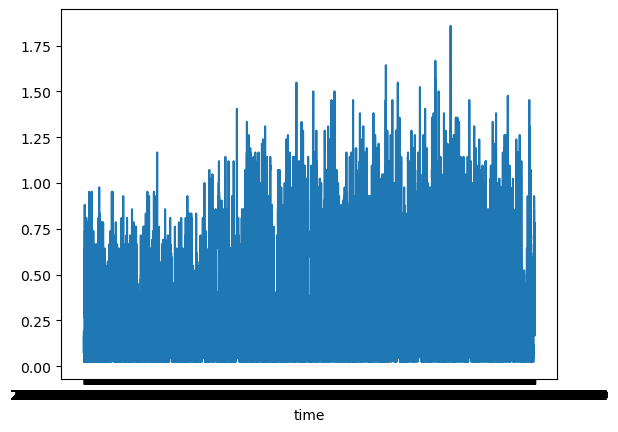

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Histogram of average rides in a time chunk


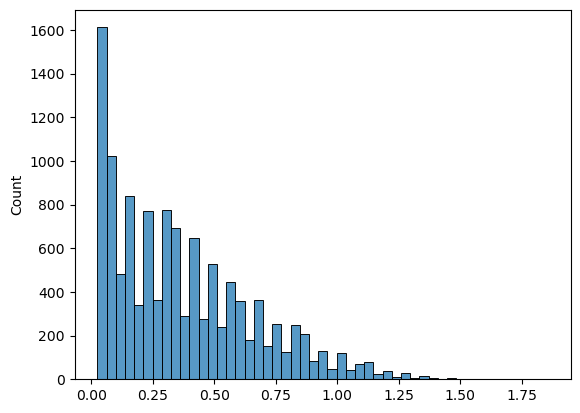

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Histogram of average rides for a station


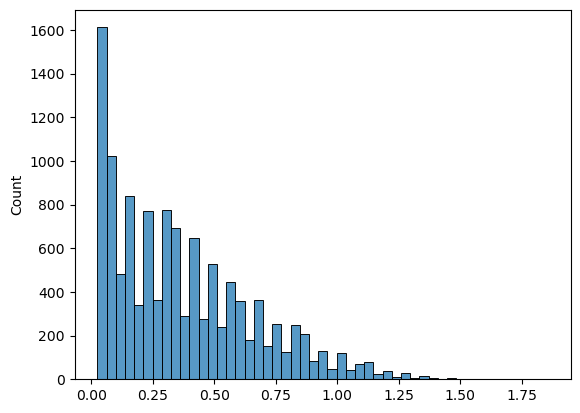

In [62]:
show_graphs(pd.read_csv('outbound23.csv'))

Inbound Rides

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average traffic through time


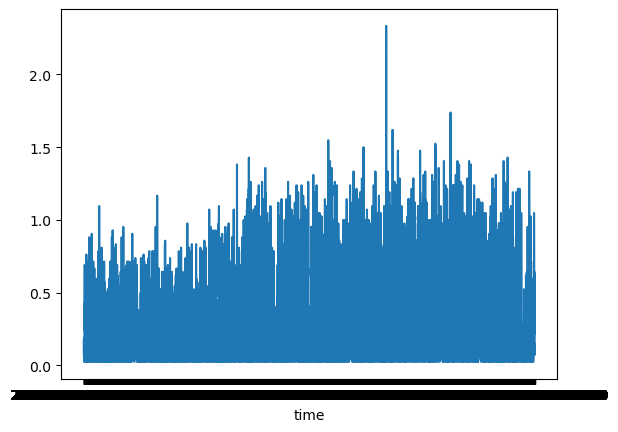

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Histogram of average rides in a time chunk


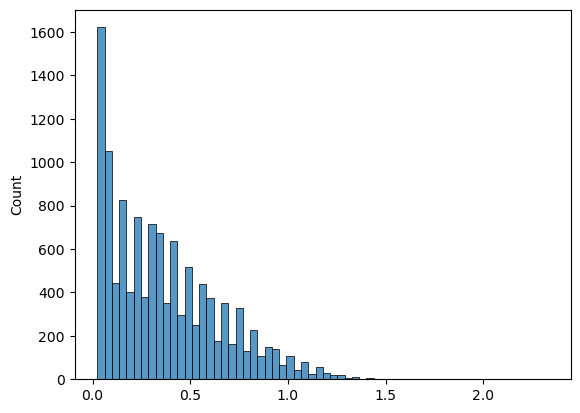

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Histogram of average rides for a station


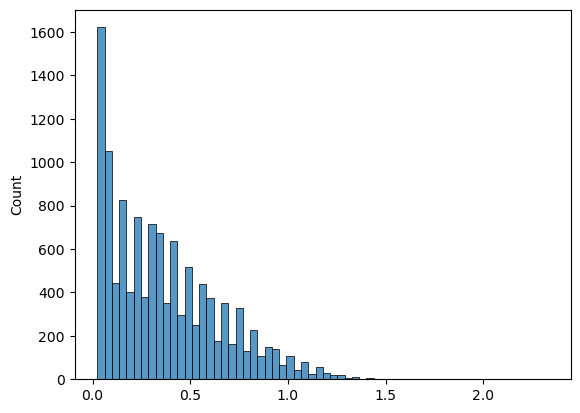

In [63]:
show_graphs(pd.read_csv('inbound23.csv'))

In [64]:
from geopy.distance import distance

In [65]:
df.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1528308,323165780CA0734B,2023-01-21 20:44:09,2023-01-21 20:48:08,Hamilton Park,JC009,Manila & 1st,JC082,40.727596,-74.044247,40.721651,-74.042884,member
1528309,8B09969A4891D5F9,2023-01-18 08:11:38,2023-01-18 08:15:30,Hamilton Park,JC009,Manila & 1st,JC082,40.727596,-74.044247,40.721651,-74.042884,member
1528314,60E075678A7EEB4A,2023-01-29 17:23:15,2023-01-29 17:24:42,Hamilton Park,JC009,Hamilton Park,JC009,40.727365,-74.044142,40.727596,-74.044247,member
1528315,F91FC1427D87CAB4,2023-01-09 12:13:47,2023-01-09 12:23:30,Hamilton Park,JC009,Hamilton Park,JC009,40.727596,-74.044247,40.727596,-74.044247,casual
1528316,735E57BAF0F1296A,2023-01-10 07:58:31,2023-01-10 08:08:16,Grand St,JC102,Hamilton Park,JC009,40.715178,-74.037683,40.727596,-74.044247,member


Creating dataframes to calculate distances between all pairs of stations

In [66]:
in_distdf = df.drop(['started_at', 'start_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng','start_station_name','end_station_name','member_casual'], axis=1)
#in_distdf = in_df[(in_df['ended_at'] >= '2021-06-01 00:00:00') & (in_df['ended_at'] <= '2021-06-30 23:59:59')]
in_distdf['station_id'] = df['end_station_id']
in_distdf['latitude'] = df['end_lat']
in_distdf['longitude'] = df['end_lng']
in_distdf = in_distdf.drop(['ended_at', 'end_station_id', 'ended_at'], axis=1)

In [67]:
out_distdf = df.drop(['ended_at', 'end_station_id','start_lat', 'start_lng', 'end_lat', 'end_lng','start_station_name','end_station_name','member_casual'], axis=1)
#out_distdf = out_distdf[(out_distdf['started_at'] >= '2021-06-01 00:00:00') & (out_df['started_at'] <= '2021-06-30 23:59:59')]
out_distdf['station_id'] = df['start_station_id']
out_distdf['latitude'] = df['start_lat']
out_distdf['longitude'] = df['start_lng']
out_distdf = out_distdf.drop(['started_at', 'start_station_id', 'started_at'], axis=1)

In [68]:
in_distdf

,ride_id,station_id,latitude,longitude
1528308,323165780CA0734B,JC082,40.721651,-74.042884
1528309,8B09969A4891D5F9,JC082,40.721651,-74.042884
1528314,60E075678A7EEB4A,JC009,40.727596,-74.044247
1528315,F91FC1427D87CAB4,JC009,40.727596,-74.044247
1528316,735E57BAF0F1296A,JC009,40.727596,-74.044247
...,...,...,...,...
2284893,43269529567AAE39,JC063,40.711130,-74.078900
2284895,B0AF12888308C73E,JC063,40.711130,-74.078900
2284902,C188FBEAD4829027,JC063,40.711130,-74.078900
2284906,4AFB109B8321F78A,JC063,40.711130,-74.078900


In [69]:
# in and out stations with their latitudes and longitudes
station_info = pd.concat([out_distdf, in_distdf])
station_info = station_info.drop(['ride_id'], axis=1)
station_info = station_info.groupby('station_id').mean().reset_index()

In [70]:
station_info

,station_id,latitude,longitude
0,JC002,40.714156,-74.033556
1,JC006,40.721133,-74.038039
2,JC008,40.728754,-74.032107
3,JC009,40.727584,-74.044248
4,JC013,40.714600,-74.042810
5,JC014,40.718426,-74.038888
6,JC018,40.734943,-74.059502
7,JC019,40.731153,-74.057524
8,JC020,40.723639,-74.064177
9,JC022,40.737567,-74.052431


In [71]:
# Calculating distance between all pair of stations
selected_stations = station_info['station_id'].unique()
distances  = pd.crosstab(station_info.station_id, station_info.station_id, normalize=True)
distances[:] = 0

for pos,station_i in enumerate(selected_stations[:-1]):
    if pos%368 ==0:
        print(str(pos/368*25)+'% complete')
    for station_j in selected_stations[pos+1:]:
        station_i_meta = station_info[station_info['station_id']==station_i]
        station_j_meta = station_info[station_info['station_id']==station_j]
        d_ij = distance(
            (station_i_meta['latitude'].values[0], station_i_meta['longitude'].values[0]),
            (station_j_meta['latitude'].values[0], station_j_meta['longitude'].values[0])).m
        distances.at[station_j, station_i] = d_ij
        distances.at[station_i, station_j] = d_ij

0.0% complete


In [72]:
distances

station_id,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
station_id,,,,,,,,,,,,,,,,,,,,,
JC002,0.000000,862.390425,1625.689845,1743.424513,783.490505,654.002431,3183.259192,2768.274737,2793.263492,3049.868365,...,1147.096807,3485.330406,3497.100991,1137.145909,1584.798525,366.650465,3266.028073,570.943831,2597.358186,308.216283
JC006,862.390425,0.000000,983.590390,887.897228,829.916456,309.043702,2374.718420,1986.963363,2225.727518,2192.931991,...,413.399964,2905.804649,2875.282886,411.156217,1110.418606,662.139841,2490.121280,381.744340,1734.985691,646.135587
JC008,1625.689845,983.590390,0.000000,1033.857542,1813.337775,1282.046512,2414.033285,2163.628662,2768.208984,1976.207011,...,1203.681469,3378.138104,3288.541670,572.517191,1902.189648,1579.665788,2622.648652,1068.391227,1442.482131,1320.486463
JC009,1743.424513,887.897228,1033.857542,0.000000,1446.949083,1113.296017,1525.829341,1189.529177,1739.692627,1306.504370,...,667.591732,2344.815830,2260.283609,824.972685,1070.331741,1485.302157,1681.573014,1251.781905,877.597494,1531.426159
JC013,783.490505,829.916456,1813.337775,1446.949083,0.000000,538.823503,2663.034673,2219.127615,2065.553649,2676.879836,...,784.316047,2751.150405,2783.724150,1240.821567,874.265343,437.924485,2692.030016,890.664949,2316.128958,880.610935
JC014,654.002431,309.043702,1282.046512,1113.296017,538.823503,0.000000,2529.256824,2115.842369,2213.682188,2414.038274,...,493.099321,2904.640374,2897.222772,711.414720,1028.404525,374.912214,2614.979381,403.654243,1984.670493,540.274060
JC018,3183.259192,2374.718420,2414.033285,1525.829341,2663.034673,2529.256824,0.000000,452.724634,1315.962914,664.565379,...,2036.166555,1463.459620,1270.396627,2347.803832,1867.497368,2866.351384,287.566718,2753.690147,1063.576989,3017.286897
JC019,2768.274737,1986.963363,2163.628662,1189.529177,2219.127615,2115.842369,452.724634,0.000000,1006.119798,832.098308,...,1625.074705,1355.068798,1206.134551,2011.018427,1414.863899,2440.890392,503.160610,2368.628222,1003.548845,2620.651250
JC020,2793.263492,2225.727518,2768.208984,1739.692627,2065.553649,2213.682188,1315.962914,1006.119798,0.000000,1837.662843,...,1812.403958,692.587577,723.490976,2424.172946,1208.601423,2427.723667,1123.997107,2575.289569,1944.413173,2753.187764


In [73]:
outbound_stations = pd.read_csv('outbound_stations23.csv')
outbound_stations['station_id'] = outbound_stations['station_id'].astype(str)
valid_station_ids = [sid for sid in outbound_stations.station_id if sid in distances.columns]
outbound_distances = distances[list(valid_station_ids)]
#outbound_distances = distances[list(outbound_stations.station_id)]
outbound_distances = outbound_distances[outbound_distances.index.isin(outbound_stations.station_id)]
outbound_distances = outbound_distances.reindex(sorted(outbound_distances.columns), axis=1)
outbound_distances = outbound_distances.reindex(sorted(outbound_distances.index), axis=0)
outbound_distances.to_csv('outbound_distances23.csv')
print('Outbound distances length:', len(outbound_distances))
print(print(pd.Series(outbound_distances.values.ravel()).describe()))

Outbound distances length: 42
count    1764.000000
mean     1965.888735
std      1056.769853
min         0.000000
25%      1176.144755
50%      1860.650449
75%      2768.208984
max      5283.097436
dtype: float64
None


In [74]:
inbound_stations = pd.read_csv('inbound_stations23.csv')
inbound_stations['station_id'] = inbound_stations['station_id'].astype(str)
valid_station_ids = [sid for sid in inbound_stations.station_id if sid in distances.columns]
inbound_distances = distances[list(valid_station_ids)]
#inbound_distances = distances[list(inbound_stations.station_id)]
inbound_distances = inbound_distances[inbound_distances.index.isin(inbound_stations.station_id)]
inbound_distances = inbound_distances.reindex(sorted(inbound_distances.columns), axis=1)
inbound_distances = inbound_distances.reindex(sorted(inbound_distances.index), axis=0)
inbound_distances.to_csv('inbound_distances23.csv')
print('Inbound distances length:', len(inbound_distances))
print(print(pd.Series(inbound_distances.values.ravel()).describe()))


Inbound distances length: 42
count    1764.000000
mean     1965.888735
std      1056.769853
min         0.000000
25%      1176.144755
50%      1860.650449
75%      2768.208984
max      5283.097436
dtype: float64
None


In [76]:
inbound_distances.head()

station_id,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
station_id,,,,,,,,,,,,,,,,,,,,,
JC002,0.000000,862.390425,1625.689845,1743.424513,783.490505,654.002431,3183.259192,2768.274737,2793.263492,3049.868365,...,1147.096807,3485.330406,3497.100991,1137.145909,1584.798525,366.650465,3266.028073,570.943831,2597.358186,308.216283
JC006,862.390425,0.000000,983.590390,887.897228,829.916456,309.043702,2374.718420,1986.963363,2225.727518,2192.931991,...,413.399964,2905.804649,2875.282886,411.156217,1110.418606,662.139841,2490.121280,381.744340,1734.985691,646.135587
JC008,1625.689845,983.590390,0.000000,1033.857542,1813.337775,1282.046512,2414.033285,2163.628662,2768.208984,1976.207011,...,1203.681469,3378.138104,3288.541670,572.517191,1902.189648,1579.665788,2622.648652,1068.391227,1442.482131,1320.486463
JC009,1743.424513,887.897228,1033.857542,0.000000,1446.949083,1113.296017,1525.829341,1189.529177,1739.692627,1306.504370,...,667.591732,2344.815830,2260.283609,824.972685,1070.331741,1485.302157,1681.573014,1251.781905,877.597494,1531.426159
JC013,783.490505,829.916456,1813.337775,1446.949083,0.000000,538.823503,2663.034673,2219.127615,2065.553649,2676.879836,...,784.316047,2751.150405,2783.724150,1240.821567,874.265343,437.924485,2692.030016,890.664949,2316.128958,880.610935


Creating a combined dataset of inbound and outbound stations. Few stations have no outbound rides and have only inbound rides

In [77]:
stations = pd.read_csv('stations23.csv')
stations['station_id'] = stations['station_id'].astype(str)
valid_station_ids = [sid for sid in stations.station_id if sid in distances.columns and sid in distances.index]
distances = distances[list(valid_station_ids)]
distances = distances[distances.index.isin(stations.station_id)]
distances = distances.reindex(sorted(distances.columns), axis=1)
distances = distances.reindex(sorted(distances.index), axis=0)
distances.to_csv('distances23.csv')
print('All distances length:', len(distances))
print(print(pd.Series(distances.values.ravel()).describe()))

All distances length: 42
count    1764.000000
mean     1965.888735
std      1056.769853
min         0.000000
25%      1176.144755
50%      1860.650449
75%      2768.208984
max      5283.097436
dtype: float64
None


## Deep Neural Networks - GCN

In [6]:
class FullyConnLayer(nn.Module):
    def __init__(self, c):
        super(FullyConnLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConnLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)
# final model
# a specified number of STConv blocks, followed by an output layer
class TrafficModel(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers,
                 kernel_size, K, window_size, \
                 normalization = 'sym', bias = True):
    # num_nodes = number of nodes in the input graph
    # channel_size_list =  2d array representing feature dimensions throughout the model
    # num_layers = number of STConv blocks
    # kernel_size = length of the temporal kernel
    # K = size of the chebyshev filter for the spatial convolution
    # window_size = number of historical time steps to consider
        super(TrafficModel, self).__init__()
        self.layers = nn.ModuleList([])
        for l in range(num_layers):
            input_size, hidden_size, output_size = \
            channel_size_list[l][0], channel_size_list[l][1], \
            channel_size_list[l][2]
            self.layers.append(STConv(num_nodes, input_size, hidden_size, \
                                      output_size, kernel_size, K, \
                                      normalization, bias))
        # add output layer
        self.layers.append(OutputLayer(channel_size_list[-1][-1], \
                                       window_size - 2 * num_layers * (kernel_size - 1), \
                                       num_nodes))
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight):
        for layer in self.layers[:-1]:
          x = layer(x, edge_index, edge_weight)
        out_layer = self.layers[-1]
        x = x.permute(0, 3, 1, 2)
        x = out_layer(x)
        return x

In [8]:
directory = r'C:\Users\srush\bike share model\JC_STGCN'
filename = "best_model.pt"

In [9]:
# model parameters
channels = np.array([[1, 4, 8], [8, 4, 8]]) # sequence of channel sizes

kernel_size = 3 # size of temporal kernel
K = 3 # chebyshev filter size

learning_rate = 0.01
batch_size = 10
num_epochs = 20
num_layers = 1 # number of STConv blocks
n_his = 20 # number of historical time steps to consider
n_pred = 5 # steps in the future we want to predict

train_prop = 0.7
val_prop = 0.2
test_prop = 0.1

model_save_path = os.path.join(directory, filename)

In [10]:
def data_transform(data, n_his, n_pred, device):
    # data = slice of V matrix
    # n_his = number of historical speed observations to consider
    # n_pred = number of time steps in the future to predict

    num_nodes = data.shape[1]
    num_obs = len(data) - n_his - n_pred
    x = np.zeros([num_obs, n_his, num_nodes, 1])
    y = np.zeros([num_obs, num_nodes])

    obs_idx = 0
    for i in range(num_obs):
        head = i
        tail = i + n_his
        x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        y[obs_idx] = data[tail + n_pred - 1]
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [11]:
weighted_adj_matrix_path = os.path.join('distances23.csv')
W = pd.read_csv(weighted_adj_matrix_path).drop('station_id', axis=1)

feature_vectors_path = os.path.join('combined23.csv')
V = pd.read_csv(feature_vectors_path).drop('time', axis=1)

In [12]:
W.head()

,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
0,0.000000,862.390425,1625.689845,1743.424513,783.490505,654.002431,3183.259192,2768.274737,2793.263492,3049.868365,...,1147.096807,3485.330406,3497.100991,1137.145909,1584.798525,366.650465,3266.028073,570.943831,2597.358186,308.216283
1,862.390425,0.000000,983.590390,887.897228,829.916456,309.043702,2374.718420,1986.963363,2225.727518,2192.931991,...,413.399964,2905.804649,2875.282886,411.156217,1110.418606,662.139841,2490.121280,381.744340,1734.985691,646.135587
2,1625.689845,983.590390,0.000000,1033.857542,1813.337775,1282.046512,2414.033285,2163.628662,2768.208984,1976.207011,...,1203.681469,3378.138104,3288.541670,572.517191,1902.189648,1579.665788,2622.648652,1068.391227,1442.482131,1320.486463
3,1743.424513,887.897228,1033.857542,0.000000,1446.949083,1113.296017,1525.829341,1189.529177,1739.692627,1306.504370,...,667.591732,2344.815830,2260.283609,824.972685,1070.331741,1485.302157,1681.573014,1251.781905,877.597494,1531.426159
4,783.490505,829.916456,1813.337775,1446.949083,0.000000,538.823503,2663.034673,2219.127615,2065.553649,2676.879836,...,784.316047,2751.150405,2783.724150,1240.821567,874.265343,437.924485,2692.030016,890.664949,2316.128958,880.610935


In [13]:
V.head()

,JC002,JC006,JC008,JC009,JC013,JC014,JC018,JC019,JC020,JC022,...,JC082,JC093,JC094,JC098,JC099,JC102,JC103,JC104,JC105,JC106
0,0,0,2,0,0,0,0,1,1,0,...,0,0,0,1,0,1,1,7,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,5,0,0,1,0,0,0,0,...,0,0,0,3,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,6,1,0,0,0
4,0,0,4,0,0,0,0,1,0,2,...,0,0,0,0,0,1,0,0,0,0


In [14]:
for pos, col in enumerate(W.columns):
  if col != V.columns[pos]:
    print(col, V.columns[pos])

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")
device

device(type='cuda')

In [16]:
# get graph attributes
num_samples, num_nodes = V.shape

# get splits of V matrix
len_train = round(num_samples * train_prop)
len_val = round(num_samples * val_prop)
train = V[ : len_train]
val = V[len_train : len_train + len_val]
test = V[len_train + len_val : len_train + len_val + round(num_samples * test_prop)]

# normalize values
scaler = StandardScaler()
train = np.nan_to_num(scaler.fit_transform(train))
val = np.nan_to_num(scaler.transform(val))
test = np.nan_to_num(scaler.transform(test))

# create training examples using helper function
x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

# create torch data iterables for training
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

# format graph for pyg layer inputs
G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

In [88]:
model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [90]:
def evaluate_model(model, loss, data_iter, edge_index, edge_weight, device):
  model.eval()
  l_sum, n = 0.0, 0
  with torch.no_grad():
      for x, y in data_iter:
          y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
          l = loss(y_pred, y)
          l_sum += l.item() * y.shape[0]
          n += y.shape[0]
      return l_sum / n

def evaluate_metric(model, data_iter, scaler, edge_index, edge_weight, device):
    model.eval()
    epsilon = 1e-6
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x.to(device), \
                                                    edge_index, \
                                                    edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / (y+epsilon)).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, RMSE

In [91]:
min_val_loss = np.inf
for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  l_sum, n = 0.0, 0

  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):

    y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
    l = loss(y_pred, y)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    l_sum += l.item() * y.shape[0]
    n += y.shape[0]

  #validation loss
  val_loss = evaluate_model(model, loss, val_iter, edge_index, edge_weight, device)
  if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model.state_dict(), model_save_path)
  print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

Batch:   0%|          | 0/850 [00:00<?, ?it/s]

Epoch:   5%|▌         | 1/20 [13:15<4:11:49, 795.23s/it]

epoch 1 , train loss: 0.9356339918407856 , validation loss: 1.2488938384639519


Epoch:  10%|█         | 2/20 [25:29<3:47:44, 759.13s/it]

epoch 2 , train loss: 0.8958661660801138 , validation loss: 1.2319930799586885


Epoch:  15%|█▌        | 3/20 [37:48<3:32:33, 750.23s/it]

epoch 3 , train loss: 0.8846336970448297 , validation loss: 1.215406874716653


Epoch:  20%|██        | 4/20 [49:29<3:14:51, 730.72s/it]

epoch 4 , train loss: 0.8755941214156145 , validation loss: 1.1909350849202482


Epoch:  25%|██▌       | 5/20 [59:07<2:48:55, 675.72s/it]

epoch 5 , train loss: 0.8696727186181783 , validation loss: 1.1894766307127036


Epoch:  30%|███       | 6/20 [1:16:57<3:08:56, 809.72s/it]

epoch 6 , train loss: 0.8666707277578665 , validation loss: 1.2114486763800463


Epoch:  35%|███▌      | 7/20 [1:37:15<3:24:19, 943.05s/it]

epoch 7 , train loss: 0.8646065391510662 , validation loss: 1.179212217981165


Epoch:  40%|████      | 8/20 [2:02:20<3:44:24, 1122.06s/it]

epoch 8 , train loss: 0.8621511665096782 , validation loss: 1.1947348018487294


Epoch:  45%|████▌     | 9/20 [2:27:09<3:46:46, 1236.93s/it]

epoch 9 , train loss: 0.8610055127830429 , validation loss: 1.1679290828985909


Epoch:  50%|█████     | 10/20 [2:51:05<3:36:21, 1298.13s/it]

epoch 10 , train loss: 0.8579006114229473 , validation loss: 1.2059462920740562


Epoch:  55%|█████▌    | 11/20 [3:11:42<3:11:54, 1279.40s/it]

epoch 11 , train loss: 0.8556029168414823 , validation loss: 1.1902444855201388


Epoch:  60%|██████    | 12/20 [3:32:10<2:48:31, 1263.89s/it]

epoch 12 , train loss: 0.8548359724705938 , validation loss: 1.1768587267079655


Epoch:  65%|██████▌   | 13/20 [3:52:19<2:25:30, 1247.15s/it]

epoch 13 , train loss: 0.8543925068926917 , validation loss: 1.195248017176497


Epoch:  70%|███████   | 14/20 [4:11:36<2:02:00, 1220.16s/it]

epoch 14 , train loss: 0.8514448755947258 , validation loss: 1.1805234942175433


Epoch:  75%|███████▌  | 15/20 [4:31:41<1:41:16, 1215.31s/it]

epoch 15 , train loss: 0.8522420541339687 , validation loss: 1.1829672536200733


Epoch:  80%|████████  | 16/20 [4:51:46<1:20:49, 1212.28s/it]

epoch 16 , train loss: 0.8510851417186823 , validation loss: 1.1765073744055146


Epoch:  85%|████████▌ | 17/20 [5:05:52<55:07, 1102.35s/it]  

epoch 17 , train loss: 0.8502876766996157 , validation loss: 1.1860972848137468


Epoch:  90%|█████████ | 18/20 [5:16:59<32:23, 971.51s/it] 

epoch 18 , train loss: 0.8495903736441338 , validation loss: 1.1973728671540063


Epoch:  95%|█████████▌| 19/20 [5:35:41<16:56, 1016.63s/it]

epoch 19 , train loss: 0.8492494760778951 , validation loss: 1.1737321475980786


Epoch: 100%|██████████| 20/20 [5:53:22<00:00, 1060.12s/it]

epoch 20 , train loss: 0.8480897524411858 , validation loss: 1.1730373317817278


In [92]:
#model with least validation loss
best_model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

#evaluating on test set
l = evaluate_model(best_model, loss, test_iter, edge_index, edge_weight, device)

In [94]:
MAE, RMSE = evaluate_metric(best_model, test_iter, scaler, edge_index, edge_weight, device)
print("test loss:", l, "\nMAE:", MAE, ", RMSE:", RMSE)

test loss: 1.0595289428887151 
MAE: 0.7677669005079172 , RMSE: 1.1822455666872687


In [96]:
predict_model = best_model

pred_save_path = os.path.join(directory, 'predictions_testing.csv')

In [97]:
def get_predictions(model, pred_iter, scaler, edge_index, edge_weight, num_nodes, device):
    model.eval()
    with torch.no_grad():
      for x, y in pred_iter:
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
        y_pred = scaler.inverse_transform(model(x.to(device), \
                                                edge_index, \
                                                edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
        y_pred = y_pred.reshape(-1, num_nodes)

      return y, y_pred

In [105]:
# create prediction set
pred_len = 144 #last 3 days

pred_set = V[(-pred_len - n_his - n_pred):]
pred_set = np.nan_to_num(scaler.transform(pred_set))
x_pred, y_pred = data_transform(pred_set, n_his, n_pred, device)
pred_data = torch.utils.data.TensorDataset(x_pred, y_pred)
pred_iter = torch.utils.data.DataLoader(pred_data, pred_len + n_his + n_pred + 1)

predictions = get_predictions(predict_model, pred_iter, scaler, edge_index, edge_weight, 42, device)
np.savetxt(pred_save_path, predictions[1], delimiter=',')

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

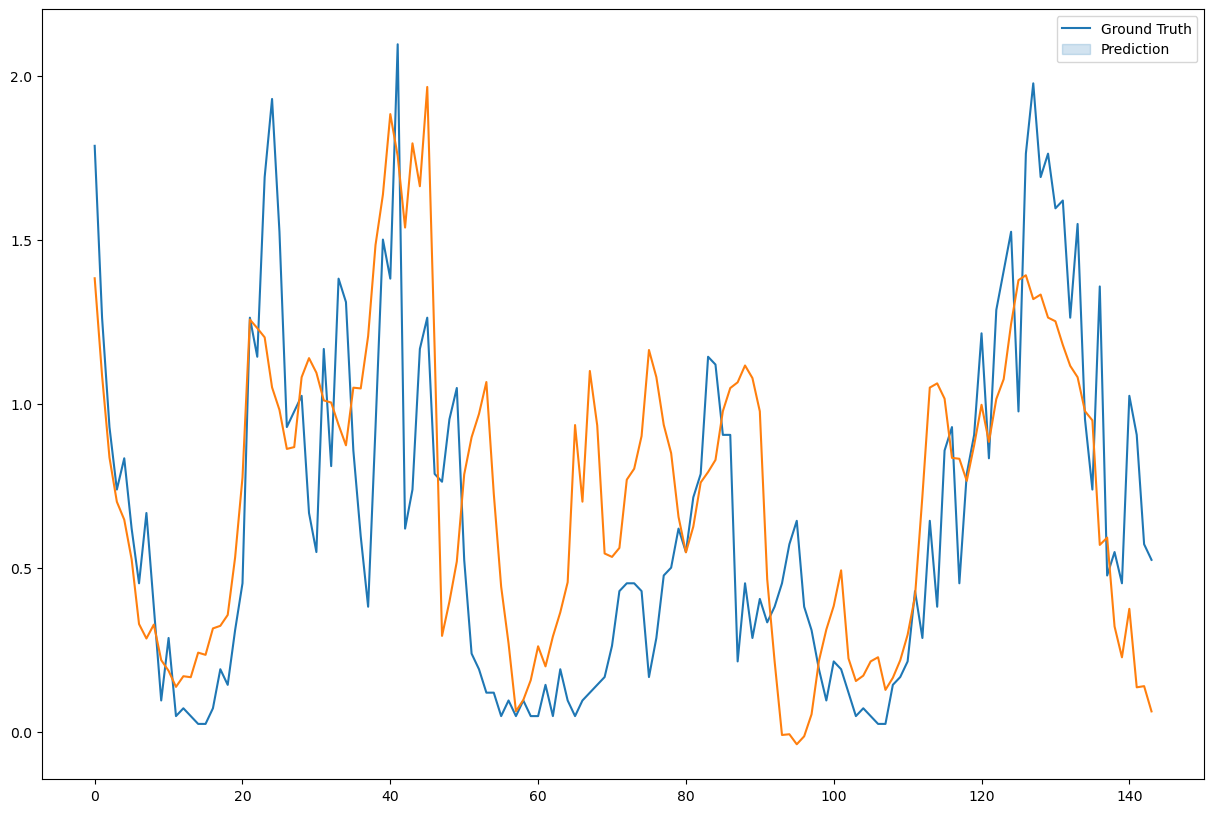

In [106]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.lineplot(y=summed_test_truth, x=range(len(summed_test_preds)))
sns.lineplot(y=summed_test_preds, x=range(len(summed_test_preds)))
plt.legend(labels=['Ground Truth', 'Prediction'])

In [107]:
print(len(summed_test_truth))
print(len(summed_test_preds))
print(len(range(len(summed_test_preds))))

144
144
144


c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


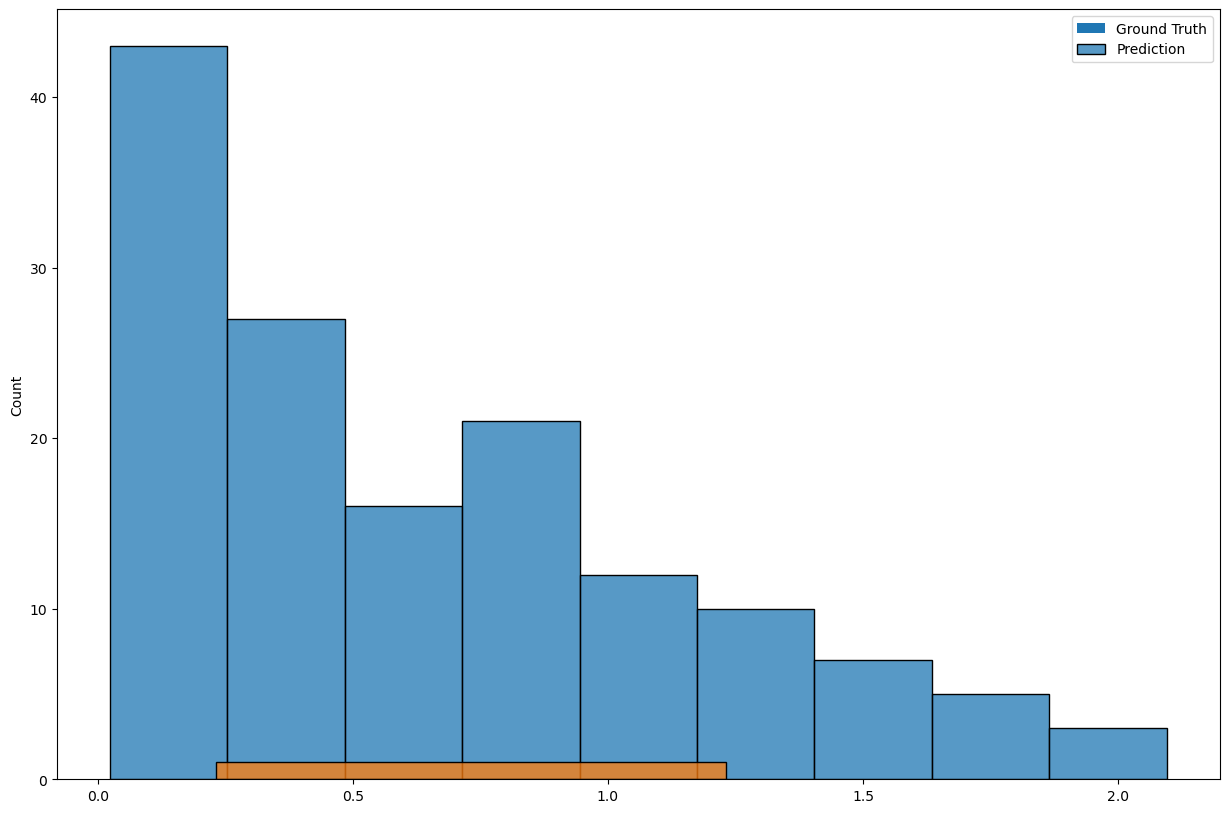

In [102]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction'])

c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\srush\miniconda3\envs\cnncuda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


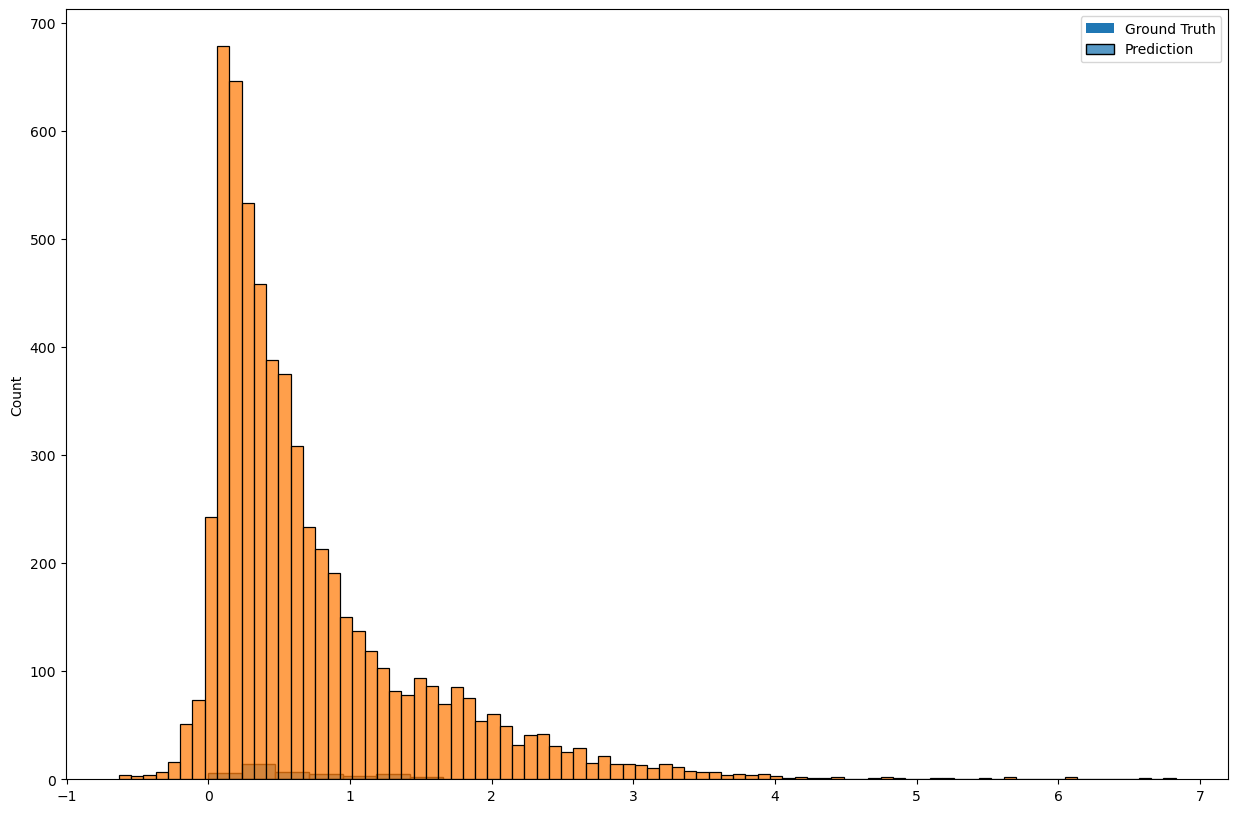

In [103]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=0)
summed_test_preds = test_preds.mean(axis=0)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);